In [306]:
pwd()

'/Users/mamadoubousso/Documents/GitHub/deep-learning-v2-pytorch/convolutional-neural-networks/cifar-cnn'

In [307]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [308]:
data_dir = 'signs'

batch_size = 20
# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([
                                       transforms.Resize([400, 400]),
                                       transforms.CenterCrop(400),
                                       # transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])
#         transforms.Resize([256, 256]),
#         transforms.RandomCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor()
            
#            transforms.Resize((224,224)),
                                       #transforms.CenterCrop(224),
#                                       transforms.ToTensor(),

test_transforms = transforms.Compose([transforms.Resize((400,400)),
                                      transforms.CenterCrop(400),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

# Pass transforms in here, then run th next cell to see how the transforms look

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
val_data = datasets.ImageFolder(data_dir + '/valid', transform=train_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size= batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
validloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

In [309]:

# specify the image classes
classes = ['dog', 'dragon', 'goat', 'horse', 'monkey',
           'ox', 'pig', 'rabbit', 'ratt', 'rooster','snake','tiger']

In [310]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [311]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

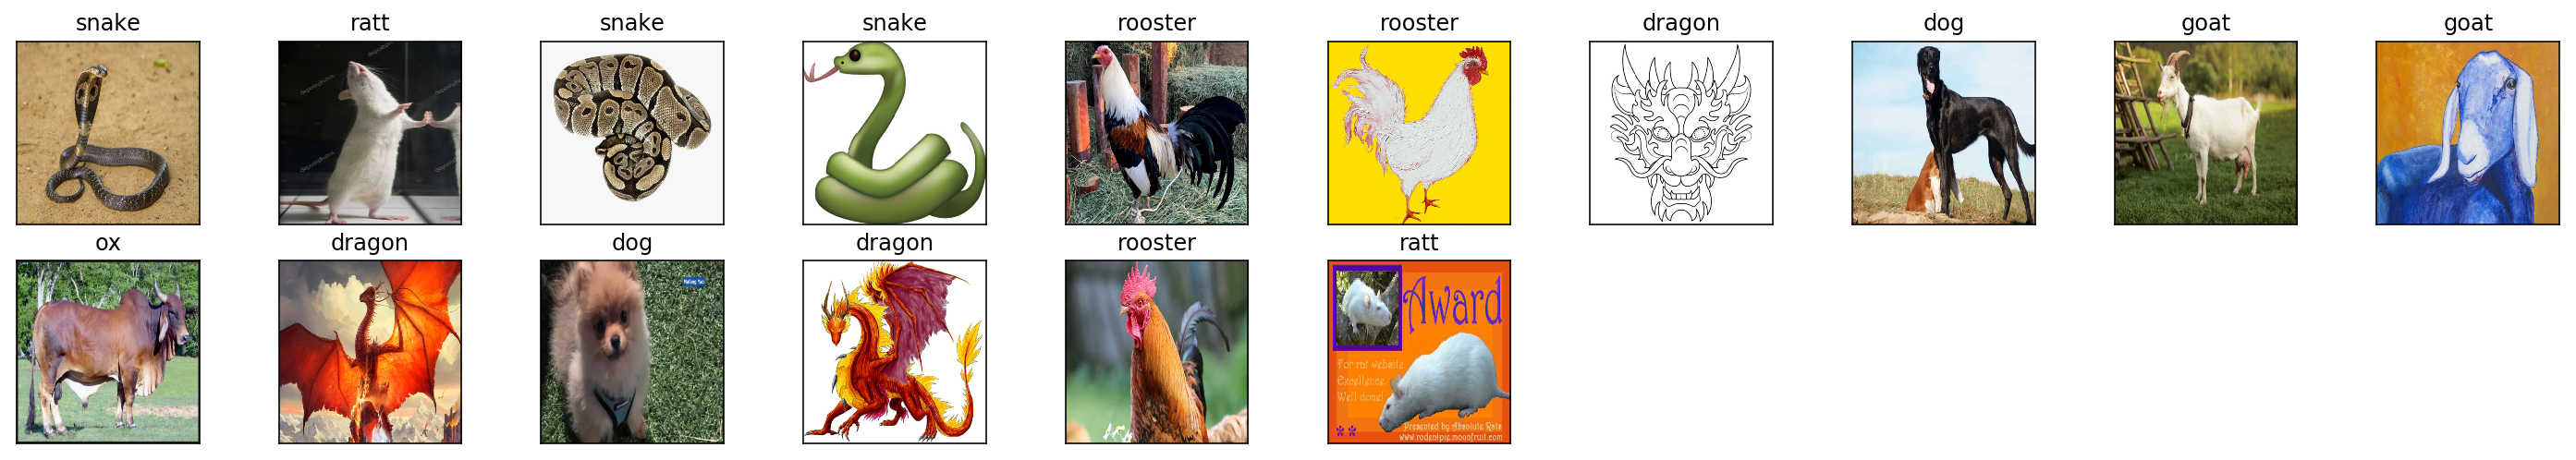

In [312]:
import numpy as np
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(16):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

In [313]:
import torch.nn as nn
import torch.nn.functional as F

# Adopt the same model as the Cifar_nn one 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 50 * 50, 500)
        # linear layer (500 -> 12)
        self.fc2 = nn.Linear(500, 12)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1,  64*50 * 50)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=160000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=12, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [314]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        #print(output.shape)
        #print(target.shape)
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in validloader:
        # move tensors to GPU if CUDA is available
        #print(type(data))
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

/Users/mamadoubousso/anaconda/lib/python3.6/site-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch: 1 	Training Loss: 2.415403 	Validation Loss: 2.347117
Validation loss decreased (inf --> 2.347117).  Saving model ...
Epoch: 2 	Training Loss: 2.249417 	Validation Loss: 2.167920
Validation loss decreased (2.347117 --> 2.167920).  Saving model ...
Epoch: 3 	Training Loss: 2.066007 	Validation Loss: 2.073957
Validation loss decreased (2.167920 --> 2.073957).  Saving model ...
Epoch: 4 	Training Loss: 1.899021 	Validation Loss: 1.857249
Validation loss decreased (2.073957 --> 1.857249).  Saving model ...
Epoch: 5 	Training Loss: 1.755996 	Validation Loss: 1.839421
Validation loss decreased (1.857249 --> 1.839421).  Saving model ...
Epoch: 6 	Training Loss: 1.604243 	Validation Loss: 1.734821
Validation loss decreased (1.839421 --> 1.734821).  Saving model ...
Epoch: 7 	Training Loss: 1.439756 	Validation Loss: 1.752734
Epoch: 8 	Training Loss: 1.220903 	Validation Loss: 1.737087
Epoch: 9 	Training Loss: 0.938396 	Validation Loss: 1.847871
Epoch: 10 	Training Loss: 0.641843 	Valida